In [1]:
# Tratamiento de datos

import pandas as pd  # Manipulación y análisis de datos.
import numpy as np  # Soporte para vectores y matrices.

# Gráficos

import matplotlib.pyplot as plt  # Creación de gráficos estáticos, animados e interactivos.
from matplotlib import style  # Personalización del estilo de los gráficos.

# Preprocesado y modelado

from scipy.stats import pearsonr  # Coeficiente de correlación de Pearson.
from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Métricas para evaluar modelos.
import statsmodels.api as sm  # Modelos estadísticos y econometricos.
import statsmodels.formula.api as smf  # Modelo estadísticos con fórmulas.
from statsmodels.stats.anova import anova_lm  # Análisis de varianza.
from scipy import stats  # Funciones estadísticas.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler  # Preprocesamiento de datos.
import category_encoders  # Codificación de variables categóricas.
import missingno as msno  # Visualización de datos faltantes.
from sklearn.pipeline import Pipeline  # Cadena de transformaciones con un estimador final.
from sklearn.experimental import enable_iterative_imputer  # Permitir uso de IterativeImputer.
from sklearn.impute import IterativeImputer  # Imputación de datos faltantes.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Modelos de ensamble.
from sklearn.model_selection import GridSearchCV, cross_val_score  # Búsqueda de hiperparámetros y validación cruzada.

# Deep Learning
import tensorflow as tf  # Biblioteca de Deep Learning.
from tensorflow.keras import layers, models  # Construcción de modelos de deep learning.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks para controlar el entrenamiento.
from keras.models import Sequential  # Creación de modelos secuenciales.
from keras.layers import Dense, Dropout, BatchNormalization  # Capas para construir modelos.
from keras import regularizers  # Regularización de modelos.


In [2]:
# Cargamos el archivo csv con los datos

df_central = pd.read_csv("https://raw.githubusercontent.com/jesusvillaalvarez/TFM_KSCHOL/main/5.ARCHIVOS/df_central_2_1.csv")

df_central.head()


,Unnamed: 0,Fecha,Period,PREVISION,E_SIMEL,DESVIO,f_PREV_HIGH,f_PREV_LOW,f_RUN,Dia_Semana,Es_fin_semana,Año,Mes,Día
0,0,2021-01-01,1,0.0,0.0,0.0,0,0,0,4,False,2021,1,1
1,1,2021-01-01,2,0.0,0.0,0.0,0,0,0,4,False,2021,1,1
2,2,2021-01-01,3,0.0,0.0,0.0,0,0,0,4,False,2021,1,1
3,3,2021-01-01,4,0.0,0.0,0.0,0,0,0,4,False,2021,1,1
4,4,2021-01-01,5,0.0,0.0,0.0,0,0,0,4,False,2021,1,1


In [3]:
# Eliminamos las columnas innecesarias

df_central = df_central.drop(columns=['Unnamed: 0', 'DESVIO', 'f_PREV_HIGH', 'f_PREV_LOW'])



In [4]:
# Convertimos la columna 'Fecha' a Datetime para hacer las división en dos dfs

df_central['Fecha'] = pd.to_datetime(df_central['Fecha'])

# Dividimos el DataFrame en dos según las fechas especificas

df_inicio = df_central[df_central['Fecha'] <= '2023-10-31']
df_final = df_central[df_central['Fecha'] >= '2023-11-05']

# Eliminamos la columna 'Fecha' de ambos DataFrames para poder preparar el modelo de Deep Learning

df_inicio = df_inicio.drop(columns=['Fecha'])
df_final = df_final.drop(columns=['Fecha'])



In [5]:
# Preparamos df_inicio eliminando la variables objetivo del conjunto de entrenamiento (X) y especificamos la variable objetivo del conjunto de prueba (y)

X = df_inicio.drop('E_SIMEL', axis=1)
y = df_inicio['E_SIMEL']

# Dividimos los datos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizamos las características, paso necesario para el modelo de deep learning

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verificamos las dimensiones de los conjuntos de datos para asegurarnos de que todo está correcto

(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)


((19764, 8), (4942, 8), (19764,), (4942,))

In [6]:
# Definimos la arquitectura del modelo, con dos capas ocultas de 64 unidades cada una con la función de activación 'relu', que proporciona
# capacidad de modelado no lineal.
# una capa de salida sin función de activación


model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)

history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=[early_stopping, reduce_lr], verbose=1)


# Evaluamos el conjunto de prueba

test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Loss en el conjunto de prueba: {test_loss}, MAE: {test_mae}")




Epoch 1/100


495/495 [==============================] - 2s 2ms/step - loss: 85.6433 - mae: 4.6969 - val_loss: 40.2485 - val_mae: 3.0502 - lr: 0.0010
Epoch 2/100
495/495 [==============================] - 1s 1ms/step - loss: 55.2828 - mae: 3.7875 - val_loss: 38.9727 - val_mae: 2.8392 - lr: 0.0010
Epoch 3/100
495/495 [==============================] - 1s 2ms/step - loss: 51.0915 - mae: 3.6202 - val_loss: 38.4024 - val_mae: 2.8108 - lr: 0.0010
Epoch 4/100
495/495 [==============================] - 1s 1ms/step - loss: 50.6699 - mae: 3.5848 - val_loss: 39.6561 - val_mae: 3.0204 - lr: 0.0010
Epoch 5/100
495/495 [==============================] - 1s 1ms/step - loss: 49.8041 - mae: 3.5650 - val_loss: 39.3850 - val_mae: 2.8001 - lr: 0.0010
Epoch 6/100
495/495 [==============================] - 1s 1ms/step - loss: 52.4358 - mae: 3.6521 - val_loss: 38.0845 - val_mae: 2.8480 - lr: 0.0010
Epoch 7/100
495/495 [==============================] - 1s 1ms/step - loss: 49.4967 - mae: 3.5309 - val_loss:

In [7]:
# Configuramos el imputador MICE con GradientBoostingRegressor y el estimador

mice_imputer = IterativeImputer(estimator=GradientBoostingRegressor(
                                    n_estimators=100,
                                    max_depth=10,
                                    min_samples_split=4,
                                    min_samples_leaf=2,
                                    max_features='sqrt'),
                                    max_iter=10, random_state=42)

# Preparamos los datos para el entrenamiento del imputador MICE eliminando la variable objetivo E_SIMEL

X_mice = df_inicio.drop(columns=['E_SIMEL'])

# Entrenamos el imputador MICE

mice_imputer.fit(X_mice)

# Imprimimos confirmación

"Imputador MICE entrenado con éxito."



'Imputador MICE entrenado con éxito.'

In [8]:
# Seleccionamos las filas del dia 5 del df_final para hacer el tratamiento de la variable f_RUN

df_final_05_11 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 5)]

df_final_05_11_para_imputar = df_final_05_11.drop(['E_SIMEL'], axis=1)

df_final_05_11_para_imputar[['f_RUN']] = np.nan  # Primero convertimos la columna f_RUN a NaN

# En la variable creada para la imputación, predecimos los valores para las columnas siguientes

valores_imputados = mice_imputer.transform(df_final_05_11_para_imputar[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

# Realmente solo queremos imputar la columna f_RUN, por lo tanto cogemos solo los valores imputados a la columna en concreto y
# establecemos una condición que si los valores son más grandes que 0.2 establecemos un 1, y si son inferiores establecemos un 0.

valores_imputados_f_RUN = np.where(valores_imputados[:, 2]> 0.2, 1, 0)

df_final_05_11.loc[:, 'f_RUN'] = valores_imputados_f_RUN



In [9]:
# Preparamos los datos de df_final_05_11 para la predicción quitando la variable objetivo

X_final_05_11 = df_final_05_11.drop(['E_SIMEL'], axis=1)

# Normalización de los datos

X_final_05_11_scaled = scaler.transform(X_final_05_11)

# Realizamos la predicciones de E_SIMEL con el modelo de deep learning

e_simel_predicciones = model.predict(X_final_05_11_scaled)

e_simel_predicciones = np.maximum(e_simel_predicciones, 0)

# Mostramos los resultados de la predicción

e_simel_predicciones[:25]



1/1 [==============================] - 0s 80ms/step


array([[0.5725751 ],
       [0.51202583],
       [0.4514761 ],
       [0.39262104],
       [0.34881783],
       [0.357687  ],
       [0.35219765],
       [0.34502172],
       [0.3678546 ],
       [0.39615202],
       [4.8212347 ],
       [0.4466629 ],
       [6.07112   ],
       [0.44264984],
       [7.4114823 ],
       [8.12932   ],
       [8.813966  ],
       [8.501184  ],
       [7.2393866 ],
       [0.47146082],
       [0.5101805 ],
       [0.5299165 ],
       [0.5983372 ],
       [0.6704922 ]], dtype=float32)

In [10]:
# Convertimos el array a una lista para facilitar la asignación a una nueva columna que llamamos 'Prediccion_E_SIMEL'

predicciones_lista = e_simel_predicciones.flatten().tolist()

# Asignar las predicciones a df_final_05_11

df_final_05_11['Prediccion_E_SIMEL'] = predicciones_lista

# Mostramos las primeras filas para verificar

df_final_05_11[['E_SIMEL', 'PREVISION', 'Prediccion_E_SIMEL']].head(25)




C:\Users\Windows 10\AppData\Local\Temp\ipykernel_84548\496075226.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_05_11['Prediccion_E_SIMEL'] = predicciones_lista


,E_SIMEL,PREVISION,Prediccion_E_SIMEL
24802,0.000,0.0,0.572575
24803,0.000,0.0,0.512026
24804,0.000,0.0,0.451476
24805,0.000,0.0,0.392621
24806,0.000,0.0,0.348818
24807,0.000,0.0,0.357687
24808,0.000,0.0,0.352198
24809,0.000,0.0,0.345022
24810,0.000,0.0,0.367855
24811,0.000,0.0,0.396152


In [11]:
# al igual que en todos los casos anteriores, hacemos un sumatorio y porcentaje de desviación para tener una primera idea de como van las predicciones

suma_real_05 = df_final_05_11['E_SIMEL'].sum()
suma_predicha_05 = df_final_05_11['Prediccion_E_SIMEL'].sum()
suma_prevision_05 = df_final_05_11['PREVISION'].sum()


if suma_real_05 != 0:
    desviacion_porcentual = 100 * (suma_predicha_05 - suma_real_05) / suma_real_05
else:
    desviacion_porcentual = float('inf')  # en caso de división por cero, retorna un valor especial para que no nos dé error



if suma_real_05 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_05 - suma_real_05) / suma_real_05
else:
    desviacion_porcentual_prevision = float('inf')  # en caso de división por cero, retorna un valor especial para que no nos dé error

print("Suma real: ", suma_real_05)
print("Suma predicha: ", suma_predicha_05)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_05)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  15.937000000000001
Suma predicha:  58.753822565078735
Desviación porcentual:  268.66300160054425 %
Suma previsión:  0.0
Desviación porcentual:  -100.0 %


In [12]:
# Una vez tenemos la primera predicción, actualizamos df_inicio con los datos del día 5. Así estamos simulando como sería
# el proceso de predicción en tiempo real

datos_dia_5 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 5)]
df_inicio_actualizado = pd.concat([df_inicio, datos_dia_5])

# Preparamos df_actualizado con los datos de df_inicio y los datos del día 5 para reentrenar el modelo de deep learning

X_actualizado = df_inicio_actualizado.drop('E_SIMEL', axis=1)
y_actualizado = df_inicio_actualizado['E_SIMEL']


# Normalizamos con fit_transform

X_total_scaled = scaler.fit_transform(X_actualizado)  # Utilizamos fit_transform 

# Y reentrenamos el modelo de deep learning con todos los datos con los parámetros utilizados para el entrenamiento inicial

model.fit(X_total_scaled, y_actualizado, epochs=100, validation_split=0.2, batch_size=32, callbacks=[early_stopping, reduce_lr], verbose=1)

# reentrenamos también el modelo imputador con los nuevos datos con todas las variables menos con E_SIMEL

mice_imputer.fit(df_inicio_actualizado[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])



Epoch 1/100
619/619 [==============================] - 1s 2ms/step - loss: 37.4961 - mae: 3.1963 - val_loss: 45.3619 - val_mae: 3.7445 - lr: 0.0010
Epoch 2/100
619/619 [==============================] - 1s 2ms/step - loss: 37.4160 - mae: 3.1936 - val_loss: 46.2433 - val_mae: 3.7271 - lr: 0.0010
Epoch 3/100
619/619 [==============================] - 1s 1ms/step - loss: 37.1311 - mae: 3.1728 - val_loss: 43.6104 - val_mae: 3.4730 - lr: 0.0010
Epoch 4/100
619/619 [==============================] - 1s 1ms/step - loss: 37.5498 - mae: 3.1972 - val_loss: 46.4601 - val_mae: 3.5799 - lr: 0.0010
Epoch 5/100
619/619 [==============================] - 1s 1ms/step - loss: 36.3609 - mae: 3.1711 - val_loss: 48.0006 - val_mae: 3.6201 - lr: 0.0010
Epoch 6/100
619/619 [==============================] - 1s 1ms/step - loss: 36.5965 - mae: 3.1613 - val_loss: 50.5713 - val_mae: 3.8575 - lr: 0.0010
Epoch 7/100
619/619 [==============================] - 1s 1ms/step - loss: 37.4977 - mae: 3.2157 - val_loss: 45.

IterativeImputer(estimator=GradientBoostingRegressor(max_depth=10,
                                                     max_features='sqrt',
                                                     min_samples_leaf=2,
                                                     min_samples_split=4),
                 random_state=42)

In [13]:
# Seleccionamos las filas del dia 6 del df_final para hacer el tratamiento de la variable f_RUN

df_final_06_11 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 6)]

df_final_06_11_para_imputar = df_final_06_11.drop(['E_SIMEL'], axis=1)

df_final_06_11_para_imputar[['f_RUN']] = np.nan  # Primero convertimos la columna f_RUN a NaN

# En la variable creada para la imputación, predecimos los valores para las columnas siguientes

valores_imputados = mice_imputer.transform(df_final_06_11_para_imputar[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

# Realmente solo queremos imputar la columna f_RUN, por lo tanto cogemos solo los valores imputados a la columna en concreto

valores_imputados_f_RUN = np.where(valores_imputados[:, 2]> 0.2, 1, 0)

df_final_06_11.loc[:, 'f_RUN'] = valores_imputados_f_RUN


# Verificamos que los valores han sido imputados correctamente
# df_final_05_11.head(25)

# Prepararamos los datos de df_final_06_11 para la predicción

X_final_06_11 = df_final_06_11.drop(['E_SIMEL'], axis=1)

# Normalizamos los datos de X_final_05_11 

X_final_06_11_scaled = scaler.transform(X_final_06_11)

# Realizamos las predicciones de E_SIMEL

e_simel_predicciones_06 = model.predict(X_final_06_11_scaled)

# Para que no haya valores negativos los transformamos a cero

e_simel_predicciones_06 = np.maximum(e_simel_predicciones_06, 0)

# Mostrar las primeras 5 predicciones
# e_simel_predicciones[:25]

# Convertimos el array de predicciones a una lista para facilitar la asignación

predicciones_lista = e_simel_predicciones_06.flatten().tolist()

# Asignamos las predicciones a una nueva columna en el Datadrame df_final_06_11

df_final_06_11['Prediccion_E_SIMEL'] = predicciones_lista

# Visualizamos las columnas para ver el resultado

df_final_06_11[['E_SIMEL', 'PREVISION', 'Prediccion_E_SIMEL']].head(25)



1/1 [==============================] - 0s 20ms/step


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_84548\2659706717.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_06_11['Prediccion_E_SIMEL'] = predicciones_lista


,E_SIMEL,PREVISION,Prediccion_E_SIMEL
24826,0.000,0.0,0.629007
24827,0.000,0.0,0.620591
24828,0.000,0.0,0.544444
24829,0.000,0.0,0.480338
24830,0.000,0.0,0.432937
24831,0.000,0.0,0.398815
24832,0.000,0.0,0.382535
24833,0.000,0.0,0.366253
24834,0.000,0.0,0.374172
24835,0.000,0.0,5.993653


In [14]:
# Sumatorios y porcentajes de desviación

suma_real_06 = df_final_06_11['E_SIMEL'].sum()
suma_predicha_06 = df_final_06_11['Prediccion_E_SIMEL'].sum()
suma_prevision_06 = df_final_06_11['PREVISION'].sum()


if suma_real_06 != 0:
    desviacion_porcentual = 100 * (suma_predicha_06 - suma_real_06) / suma_real_06
else:
    desviacion_porcentual = float('inf')  # en caso de división por cero, retorna un valor especial para que no nos dé error



if suma_real_06 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_06 - suma_real_06) / suma_real_06
else:
    desviacion_porcentual_prevision = float('inf')  # en caso de división por cero, retorna un valor especial para que no nos dé error

print("Suma real: ", suma_real_06)
print("Suma predicha: ", suma_predicha_06)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_06)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  58.542
Suma predicha:  115.35878014564514
Desviación porcentual:  97.0530220109411 %
Suma previsión:  159.4
Desviación porcentual:  172.2831471422227 %


In [15]:
# Creamos un función para agilizar el proceso de actualización, reentreno de los modelos, imputación, predicción y cálculo de las métricas

def predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente,  mes, año, df_inicio_actualizado, df_final, modelo_deep, imputador):
    """
    Función para actualizar el conjunto de entrenamiento con los datos reales de un día específico,
    realizar la imputación para el día siguiente y predecir los valores de E_SIMEL para ese día.

    Args:
    dia_actual (int): Día actual para el que se actualizarán los datos.
    dia_siguiente (int): Datos del día que queremos hacer las imputaciones y la predicción
    mes (int): Mes del día actual.
    año (int): Año del día actual.
    df_inicio_actualizado (DataFrame): DataFrame actualizado con los datos hasta el día anterior.
    df_final (DataFrame): DataFrame con los datos a predecir.
    modelo_deep (DeepLearning de TencerFlow): Modelo de Deep Learning entrenado.
    imputador (IterativeImputer): Imputador MICE entrenado.

    Returns:
    DataFrame: DataFrame con las predicciones para el día siguiente.
    DataFrame: DataFrame actualizado con los datos reales del día actual.
    """
    # Actualización de df_actualizado con los datos de dia_actual

    datos_dia_actual = df_final[(df_final['Año'] == año) & (df_final['Mes'] == mes) & (df_final['Día'] == dia_actual)]
    df_inicio_actualizado = pd.concat([df_inicio_actualizado, datos_dia_actual])

    
    # Prepararamos los datos para el modelo de deep learning

    X_actualizado = df_inicio_actualizado.drop('E_SIMEL', axis=1)
    y_actualizado = df_inicio_actualizado['E_SIMEL']

        
    # Normalizaación las características

    X_actualizado_scaled = scaler.transform(X_actualizado)

    early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)

    # Reentrenamos el modelo de deep learning con todos los datos pasándole los parámetros de modelado

    modelo_deep.fit(X_actualizado_scaled, y_actualizado, epochs=100, validation_split=0.2, batch_size=32, callbacks=[early_stopping, reduce_lr], verbose=1)

    # Reentrenamos el imputador para todas las variables menos con E_SIMEL

    imputador.fit(df_inicio_actualizado[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])    

    

      # Imputación de valores a la columna f_RUN para la predicción

    df_dia_siguiente = df_final[(df_final['Año'] == año) & (df_final['Mes'] == mes) & (df_final['Día'] == dia_siguiente)]
    df_dia_siguiente_para_imputar = df_dia_siguiente.drop(['E_SIMEL'], axis=1)
    df_dia_siguiente_para_imputar[['f_RUN']] = np.nan  
    
    valores_imputados = imputador.transform(df_dia_siguiente_para_imputar)
    
    df_dia_siguiente.loc[:, 'f_RUN'] = np.where(valores_imputados[:, 2] > 0.2, 1, 0) 

    
    
    # Preparamos los datos para la predicción con el modelo de deep learning

    X_prediccion = df_dia_siguiente.drop(['E_SIMEL'], axis=1)

    # Normalizamos los datos 

    X_prediccion_scaled = scaler.transform(X_prediccion)

    # Realizamos las predicciones de E_SIMEL
    predicted_e_simel = model.predict(X_prediccion_scaled)

    # Transformamos los valores negativos de la predicción a cero

    predicted_e_simel = np.maximum(predicted_e_simel, 0)

    # Mostramos las predicciones

    # e_simel_predicciones[:25]

    # Convertimos el array de las predicciones a una lista para facilitar la asignación
    predicciones_lista = predicted_e_simel.flatten().tolist()

    df_predicciones = df_dia_siguiente[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL']].copy()

    # En el df_prediciones creamos una nueva columna con las predicciones

    df_predicciones['Prediccion_E_SIMEL'] = predicciones_lista

    # Mostramos el resultado

    df_predicciones[['E_SIMEL', 'PREVISION', 'Prediccion_E_SIMEL']].head(25)


    

    # Calculamos las métricas: mse (Error cuadrático medio), r2 (coeficiente de determinación) y el mae(error medio absoluto)

    mse = mean_squared_error(df_predicciones['E_SIMEL'], df_predicciones['Prediccion_E_SIMEL'])
    r2 = r2_score(df_predicciones['E_SIMEL'], df_predicciones['Prediccion_E_SIMEL'])
    mae = mean_absolute_error(df_predicciones['E_SIMEL'], df_predicciones['Prediccion_E_SIMEL'])


    return df_predicciones, df_inicio_actualizado, mse, r2, mae

In [16]:
# Llamamos a la función

dia_actual = 6    # Actualización de datos con los que reentrenamos los modelos
dia_siguiente = 7    # Preparación de datos para la imputación y predicción
df_predicciones_07_11, df_inicio_actualizado, mse_07_11, r2_07_11, mae_07_11 = predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_07_11, "R²:", r2_07_11, "MAE:", mae_07_11)

Epoch 1/100
619/619 [==============================] - 1s 2ms/step - loss: 36.6773 - mae: 3.1649 - val_loss: 49.7858 - val_mae: 3.8873 - lr: 0.0010
Epoch 2/100
619/619 [==============================] - 1s 1ms/step - loss: 37.4420 - mae: 3.1894 - val_loss: 48.8350 - val_mae: 3.6553 - lr: 0.0010
Epoch 3/100
619/619 [==============================] - 1s 1ms/step - loss: 38.1914 - mae: 3.2095 - val_loss: 48.4827 - val_mae: 3.5961 - lr: 0.0010
Epoch 4/100
619/619 [==============================] - 1s 2ms/step - loss: 36.5251 - mae: 3.1787 - val_loss: 50.2820 - val_mae: 3.6372 - lr: 0.0010
Epoch 5/100
619/619 [==============================] - 1s 2ms/step - loss: 37.0553 - mae: 3.1954 - val_loss: 49.0924 - val_mae: 3.7404 - lr: 0.0010
Epoch 6/100
619/619 [==============================] - 1s 1ms/step - loss: 36.3275 - mae: 3.1557 - val_loss: 58.4819 - val_mae: 4.1533 - lr: 0.0010
Epoch 7/100
619/619 [==============================] - 1s 1ms/step - loss: 36.5265 - mae: 3.1739 - val_loss: 55.

In [17]:
# Y como en la predicción anterior calculamos los sumatorios y los porcentajes de desviación

suma_real_07_11 = df_predicciones_07_11['E_SIMEL'].sum()
suma_predicha_07_11 = df_predicciones_07_11['Prediccion_E_SIMEL'].sum()
suma_prevision_07_11 = df_predicciones_07_11['PREVISION'].sum()


if suma_real_07_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_07_11 - suma_real_07_11) / suma_real_07_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_07_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_07_11 - suma_real_07_11) / suma_real_07_11
else:
    desviacion_porcentual_prevision = float('inf')  
    

print("Suma real: ", suma_real_07_11)
print("Suma predicha: ", suma_predicha_07_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_07_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  67.97999999999999
Suma predicha:  55.02162551879883
Desviación porcentual:  -19.06203954280842 %
Suma previsión:  24.0
Desviación porcentual:  -64.6954986760812 %


In [18]:
# Llamamos a la función. Actualización de datos reales del día 7 para reentrenar los modelos
# Preparación de los datos del día posterior, en este caso del día 8, para la imputación y predicción

dia_actual = 7
dia_siguiente = 8

df_predicciones_08_11, df_inicio_actualizado, mse_08_11, r2_08_11, mae_08_11 = predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_08_11, "R²:", r2_08_11, "MAE:", mae_08_11)

Epoch 1/100
620/620 [==============================] - 1s 2ms/step - loss: 36.8364 - mae: 3.1849 - val_loss: 51.9102 - val_mae: 3.9058 - lr: 0.0010
Epoch 2/100
620/620 [==============================] - 1s 2ms/step - loss: 36.8325 - mae: 3.1870 - val_loss: 52.9722 - val_mae: 3.9328 - lr: 0.0010
Epoch 3/100
620/620 [==============================] - 1s 1ms/step - loss: 37.0266 - mae: 3.2008 - val_loss: 53.8467 - val_mae: 3.8825 - lr: 0.0010
Epoch 4/100
620/620 [==============================] - 1s 1ms/step - loss: 36.8930 - mae: 3.1995 - val_loss: 59.1275 - val_mae: 4.1367 - lr: 0.0010
Epoch 5/100
620/620 [==============================] - 1s 2ms/step - loss: 37.3634 - mae: 3.2071 - val_loss: 55.4141 - val_mae: 4.0494 - lr: 0.0010
Epoch 6/100
620/620 [==============================] - 1s 2ms/step - loss: 37.5713 - mae: 3.2033 - val_loss: 58.7749 - val_mae: 4.1443 - lr: 0.0010
Epoch 7/100
620/620 [==============================] - 1s 1ms/step - loss: 35.9905 - mae: 3.1522 - val_loss: 52.

In [19]:
# Sumatorios y porcentajes

suma_real_08_11 = df_predicciones_08_11['E_SIMEL'].sum()
suma_predicha_08_11 = df_predicciones_08_11['Prediccion_E_SIMEL'].sum()
suma_prevision_08_11 = df_predicciones_08_11['PREVISION'].sum()


if suma_real_08_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_08_11 - suma_real_08_11) / suma_real_08_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_08_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_08_11 - suma_real_08_11) / suma_real_08_11
else:
    desviacion_porcentual_prevision = float('inf')  
    

print("Suma real: ", suma_real_08_11)
print("Suma predicha: ", suma_predicha_08_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_08_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  11.296999999999999
Suma predicha:  59.288031578063965
Desviación porcentual:  424.81217648989974 %
Suma previsión:  0.0
Desviación porcentual:  -100.0 %


In [20]:
# Seguimos con el mismo proceso anterior. Llamamos a la función con los días específicos que queremos actualizar, imputar y predecir.

dia_actual = 8
dia_siguiente = 9

df_predicciones_09_11, df_inicio_actualizado, mse_09_11, r2_09_11, mae_09_11 = predecir_y_actualizar_para_un_dia(dia_actual, dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_09_11, "R²:", r2_09_11, "MAE:", mae_09_11)

Epoch 1/100
621/621 [==============================] - 1s 2ms/step - loss: 36.7192 - mae: 3.1823 - val_loss: 48.1978 - val_mae: 3.6014 - lr: 0.0010
Epoch 2/100
621/621 [==============================] - 1s 1ms/step - loss: 37.3296 - mae: 3.2106 - val_loss: 49.1349 - val_mae: 3.6723 - lr: 0.0010
Epoch 3/100
621/621 [==============================] - 1s 1ms/step - loss: 37.2409 - mae: 3.2288 - val_loss: 54.6130 - val_mae: 3.9891 - lr: 0.0010
Epoch 4/100
621/621 [==============================] - 1s 1ms/step - loss: 36.9155 - mae: 3.1918 - val_loss: 50.4646 - val_mae: 3.7081 - lr: 0.0010
Epoch 5/100
621/621 [==============================] - 1s 2ms/step - loss: 36.8751 - mae: 3.1813 - val_loss: 55.1976 - val_mae: 3.8792 - lr: 0.0010
Epoch 6/100
621/621 [==============================] - 1s 1ms/step - loss: 37.1705 - mae: 3.2121 - val_loss: 52.6358 - val_mae: 3.7094 - lr: 0.0010
Epoch 7/100
621/621 [==============================] - 1s 1ms/step - loss: 36.5730 - mae: 3.1765 - val_loss: 50.

In [21]:
# Sumatorios y procentajes

suma_real_09_11 = df_predicciones_09_11['E_SIMEL'].sum()
suma_predicha_09_11 = df_predicciones_09_11['Prediccion_E_SIMEL'].sum()
suma_prevision_09_11 = df_predicciones_09_11['PREVISION'].sum()


if suma_real_09_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_09_11 - suma_real_09_11) / suma_real_09_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_09_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_09_11 - suma_real_09_11) / suma_real_09_11
else:
    desviacion_porcentual_prevision = float('inf')  
    

print("Suma real: ", suma_real_09_11)
print("Suma predicha: ", suma_predicha_09_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_09_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  102.43700000000001
Suma predicha:  89.9802942276001
Desviación porcentual:  -12.160357851557457 %
Suma previsión:  127.30000000000001
Desviación porcentual:  24.271503460663627 %


In [22]:
# Llamamos a la función
dia_actual = 9
dia_siguiente = 10

df_predicciones_10_11, df_inicio_actualizado, mse_10_11, r2_10_11, mae_10_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_10_11, "R²:", r2_10_11, "MAE:", mae_10_11)

Epoch 1/100
621/621 [==============================] - 1s 2ms/step - loss: 36.7002 - mae: 3.1757 - val_loss: 57.0638 - val_mae: 4.0306 - lr: 0.0010
Epoch 2/100
621/621 [==============================] - 1s 1ms/step - loss: 36.2477 - mae: 3.1828 - val_loss: 53.2661 - val_mae: 3.9153 - lr: 0.0010
Epoch 3/100
621/621 [==============================] - 1s 1ms/step - loss: 37.0027 - mae: 3.1848 - val_loss: 50.0708 - val_mae: 3.7598 - lr: 0.0010
Epoch 4/100
621/621 [==============================] - 1s 1ms/step - loss: 36.8989 - mae: 3.1699 - val_loss: 57.1742 - val_mae: 4.0685 - lr: 0.0010
Epoch 5/100
621/621 [==============================] - 1s 2ms/step - loss: 36.9328 - mae: 3.1889 - val_loss: 56.0694 - val_mae: 3.9582 - lr: 0.0010
Epoch 6/100
621/621 [==============================] - 1s 1ms/step - loss: 36.7306 - mae: 3.1927 - val_loss: 60.1799 - val_mae: 4.2505 - lr: 0.0010
Epoch 7/100
621/621 [==============================] - 1s 1ms/step - loss: 36.5984 - mae: 3.2038 - val_loss: 56.

In [23]:
# Sumatorios y porcentajes

suma_real_10_11 = df_predicciones_10_11['E_SIMEL'].sum()
suma_predicha_10_11 = df_predicciones_10_11['Prediccion_E_SIMEL'].sum()
suma_prevision_10_11 = df_predicciones_10_11['PREVISION'].sum()


if suma_real_10_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_10_11 - suma_real_10_11) / suma_real_10_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_10_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_10_11 - suma_real_10_11) / suma_real_10_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_10_11)
print("Suma predicha: ", suma_predicha_10_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_10_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  58.955
Suma predicha:  105.15507960319519
Desviación porcentual:  78.36498957373453 %
Suma previsión:  112.6
Desviación porcentual:  90.99313035365958 %


In [24]:
# Llamamos a la función

dia_actual = 10
dia_siguiente = 13

df_predicciones_13_11, df_inicio_actualizado, mse_13_11, r2_13_11, mae_13_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_13_11, "R²:", r2_13_11, "MAE:", mae_13_11)

Epoch 1/100
622/622 [==============================] - 1s 2ms/step - loss: 37.4087 - mae: 3.2170 - val_loss: 48.4112 - val_mae: 3.6188 - lr: 0.0010
Epoch 2/100
622/622 [==============================] - 1s 2ms/step - loss: 36.8386 - mae: 3.1734 - val_loss: 50.2885 - val_mae: 3.6524 - lr: 0.0010
Epoch 3/100
622/622 [==============================] - 1s 2ms/step - loss: 36.4058 - mae: 3.1977 - val_loss: 57.9244 - val_mae: 4.2517 - lr: 0.0010
Epoch 4/100
622/622 [==============================] - 1s 2ms/step - loss: 36.9869 - mae: 3.1797 - val_loss: 48.8612 - val_mae: 3.6392 - lr: 0.0010
Epoch 5/100
622/622 [==============================] - 1s 1ms/step - loss: 37.5300 - mae: 3.2250 - val_loss: 49.1117 - val_mae: 3.4881 - lr: 0.0010
Epoch 6/100
622/622 [==============================] - 1s 2ms/step - loss: 36.5813 - mae: 3.1898 - val_loss: 50.7514 - val_mae: 3.6639 - lr: 0.0010
Epoch 7/100
622/622 [==============================] - 1s 1ms/step - loss: 36.9242 - mae: 3.1945 - val_loss: 53.

In [25]:
# Sumas y porcentajes

suma_real_13_11 = df_predicciones_13_11['E_SIMEL'].sum()
suma_predicha_13_11 = df_predicciones_13_11['Prediccion_E_SIMEL'].sum()
suma_prevision_13_11 = df_predicciones_13_11['PREVISION'].sum()

if suma_real_13_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_13_11 - suma_real_13_11) / suma_real_13_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_13_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_13_11 - suma_real_13_11) / suma_real_13_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_13_11)
print("Suma predicha: ", suma_predicha_13_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_13_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  107.141
Suma predicha:  48.816144943237305
Desviación porcentual:  -54.437474969211316 %
Suma previsión:  20.900000000000002
Desviación porcentual:  -80.492995211917 %


In [26]:
# Llamamos a la función

dia_actual = 13
dia_siguiente = 14

df_predicciones_14_11, df_inicio_actualizado, mse_14_11, r2_14_11, mae_14_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_14_11, "R²:", r2_14_11, "MAE:", mae_14_11)

Epoch 1/100
622/622 [==============================] - 1s 2ms/step - loss: 36.6765 - mae: 3.2048 - val_loss: 53.8203 - val_mae: 3.7454 - lr: 0.0010
Epoch 2/100
622/622 [==============================] - 1s 2ms/step - loss: 37.0925 - mae: 3.2019 - val_loss: 60.3228 - val_mae: 4.0534 - lr: 0.0010
Epoch 3/100
622/622 [==============================] - 1s 2ms/step - loss: 37.0011 - mae: 3.1959 - val_loss: 56.6936 - val_mae: 3.8823 - lr: 0.0010
Epoch 4/100
622/622 [==============================] - 1s 2ms/step - loss: 36.6380 - mae: 3.1792 - val_loss: 54.1987 - val_mae: 3.9451 - lr: 0.0010
Epoch 5/100
622/622 [==============================] - 1s 2ms/step - loss: 36.7971 - mae: 3.2119 - val_loss: 48.0186 - val_mae: 3.5048 - lr: 0.0010
Epoch 6/100
622/622 [==============================] - 1s 2ms/step - loss: 37.5440 - mae: 3.2309 - val_loss: 53.0101 - val_mae: 3.8720 - lr: 0.0010
Epoch 7/100
622/622 [==============================] - 1s 2ms/step - loss: 36.8881 - mae: 3.2103 - val_loss: 56.

In [27]:
# Sumatorios y porcentajes

suma_real_14_11 = df_predicciones_14_11['E_SIMEL'].sum()
suma_predicha_14_11 = df_predicciones_14_11['Prediccion_E_SIMEL'].sum()
suma_prevision_14_11 = df_predicciones_14_11['PREVISION'].sum()

if suma_real_14_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_14_11 - suma_real_14_11) / suma_real_14_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_14_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_14_11 - suma_real_14_11) / suma_real_14_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_14_11)
print("Suma predicha: ", suma_predicha_14_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_14_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  112.33099999999999
Suma predicha:  75.55607509613037
Desviación porcentual:  -32.7380018907244 %
Suma previsión:  120.5
Desviación porcentual:  7.272257880727503 %


In [28]:
# Llamamos a la función

dia_actual = 14
dia_siguiente = 15

df_predicciones_15_11, df_inicio_actualizado, mse_15_11, r2_15_11, mae_15_11 = predecir_y_actualizar_para_un_dia(dia_actual,dia_siguiente, 11, 2023, df_inicio_actualizado, df_final, model, mice_imputer)
print("MSE:", mse_15_11, "R²:", r2_15_11, "MAE:", mae_15_11)

Epoch 1/100
623/623 [==============================] - 1s 2ms/step - loss: 36.6156 - mae: 3.2208 - val_loss: 59.5967 - val_mae: 4.1438 - lr: 0.0010
Epoch 2/100
623/623 [==============================] - 1s 1ms/step - loss: 36.9407 - mae: 3.2153 - val_loss: 52.1364 - val_mae: 3.7550 - lr: 0.0010
Epoch 3/100
623/623 [==============================] - 1s 2ms/step - loss: 35.9115 - mae: 3.1795 - val_loss: 58.8104 - val_mae: 3.9716 - lr: 0.0010
Epoch 4/100
623/623 [==============================] - 1s 2ms/step - loss: 35.9207 - mae: 3.1598 - val_loss: 60.9334 - val_mae: 4.0777 - lr: 0.0010
Epoch 5/100
623/623 [==============================] - 1s 2ms/step - loss: 36.6240 - mae: 3.2000 - val_loss: 63.7278 - val_mae: 4.2053 - lr: 0.0010
Epoch 6/100
623/623 [==============================] - 1s 2ms/step - loss: 36.8174 - mae: 3.2046 - val_loss: 60.3666 - val_mae: 4.0533 - lr: 0.0010
Epoch 7/100
623/623 [==============================] - 1s 2ms/step - loss: 36.8382 - mae: 3.1929 - val_loss: 58.

In [29]:
# Sumas y porcentajes

suma_real_15_11 = df_predicciones_15_11['E_SIMEL'].sum()
suma_predicha_15_11 = df_predicciones_15_11['Prediccion_E_SIMEL'].sum()
suma_prevision_15_11 = df_predicciones_15_11['PREVISION'].sum()

if suma_real_15_11 != 0:
    desviacion_porcentual = 100 * (suma_predicha_15_11 - suma_real_15_11) / suma_real_15_11
else:
    desviacion_porcentual = float('inf')  



if suma_real_15_11 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_15_11 - suma_real_15_11) / suma_real_15_11
else:
    desviacion_porcentual_prevision = float('inf')  

print("Suma real: ", suma_real_15_11)
print("Suma predicha: ", suma_predicha_15_11)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_15_11)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")

Suma real:  88.333
Suma predicha:  93.20066690444946
Desviación porcentual:  5.51058710159223 %
Suma previsión:  131.89999999999998
Desviación porcentual:  49.32131819365354 %


In [30]:
# Concatenamos todos los Dataframes que contienen las prediccions, previsiones y datos reales para calcular las méstricas en conjunto

df_predicciones_totales = pd.concat([df_final_05_11, df_final_06_11, df_predicciones_07_11, 
                                     df_predicciones_08_11, df_predicciones_09_11,df_predicciones_10_11, 
                                     df_predicciones_13_11, df_predicciones_14_11, df_predicciones_15_11])

In [31]:
# Cálculo de las métricas para ver si nos indican si mejoran los errores entren la predicción (Prediccion_E_SIMEL), previsión (PREVISION)y producción real(E_SIMEL)

def calcular_metricas(df):
    mae = mean_absolute_error(df['E_SIMEL'], df['Prediccion_E_SIMEL'])
    mse = mean_squared_error(df['E_SIMEL'], df['Prediccion_E_SIMEL'])
    r2 = r2_score(df['E_SIMEL'], df['Prediccion_E_SIMEL'])
    return mae, mse, r2

# Métricas para la predicciones

mae_pred, mse_pred, r2_pred = calcular_metricas(df_predicciones_totales)

# Cambiamos la columna de predicción por la de previsión

df_previsiones = df_predicciones_totales.copy()
df_previsiones['Prediccion_E_SIMEL'] = df_previsiones['PREVISION']

# Métricas para la previsión

mae_prev, mse_prev, r2_prev = calcular_metricas(df_previsiones)

# Visualizamos los resultados

print("MAE Predicciones: ", mae_pred)
print("MSE Predicciones: ", mse_pred)
print("R² Predicciones: ", r2_pred)
print("MAE Previsiones: ", mae_prev)
print("MSE Previsiones: ", mse_prev)
print("R² Previsiones: ", r2_prev)

MAE Predicciones:  2.964409713065183
MSE Predicciones:  29.597694122493554
R² Predicciones:  0.41480655146047174
MAE Previsiones:  2.3999490740740743
MSE Previsiones:  35.93822944907407
R² Previsiones:  0.2894440918718205


In [32]:
# sumamos todos los valores de las columnas que queremo comparar

suma_e_simel = df_predicciones_totales['E_SIMEL'].sum()
sumas_totales_predicciones = df_predicciones_totales['Prediccion_E_SIMEL'].sum()
sumas_previsiones = df_predicciones_totales['PREVISION'].sum()


# Calculamos las diferencias entre la prediccion y la previsión respecto la producción real E_SIMEL

diferencia_prediccion_vs_produccion_real = abs(sumas_totales_predicciones - suma_e_simel)
diferencia_prevision_vs_produccion_real = abs(sumas_previsiones - suma_e_simel)


# Imprimimos los resultados para poder visualizar si mejoramos las previsiones a lo largo de todas las predicciones.

print(f"Suma de los valores en la columna E_SIMEL: {suma_e_simel}")
print(f"Suma de las predicciones: {sumas_totales_predicciones}")
print(f"Suma de las previsiones : {sumas_previsiones}")


print(f"Diferencia entre predicciones totales y E_SIMEL total: {diferencia_prediccion_vs_produccion_real}")
print(f"Diferencia entre previsiones y E_SIMEL total: {diferencia_prevision_vs_produccion_real}")


# Calculamos la diferencia entre la predicción y la previsión para saber si el modelo de predicción mejora la previsión

diferencia = diferencia_prediccion_vs_produccion_real - diferencia_prevision_vs_produccion_real

if diferencia_prediccion_vs_produccion_real > diferencia_prevision_vs_produccion_real:
    print(f"No mejoramos la predicción respecto la PREVISION real en: {diferencia}, por lo tanto, con este modelo, no estamos mejorando las previsiones.")
else:
    print(f"La predicción es MEJOR que la previsión en: {-diferencia} unidades, por lo tanto, cumplimos nuestro objetivo de mejorar la PREVISIÓN.")

Suma de los valores en la columna E_SIMEL: 622.953
Suma de las predicciones: 701.1305205821991
Suma de las previsiones : 696.6
Diferencia entre predicciones totales y E_SIMEL total: 78.17752058219912
Diferencia entre previsiones y E_SIMEL total: 73.64700000000005
No mejoramos la predicción respecto la PREVISION real en: 4.530520582199074, por lo tanto, con este modelo, no estamos mejorando las previsiones.


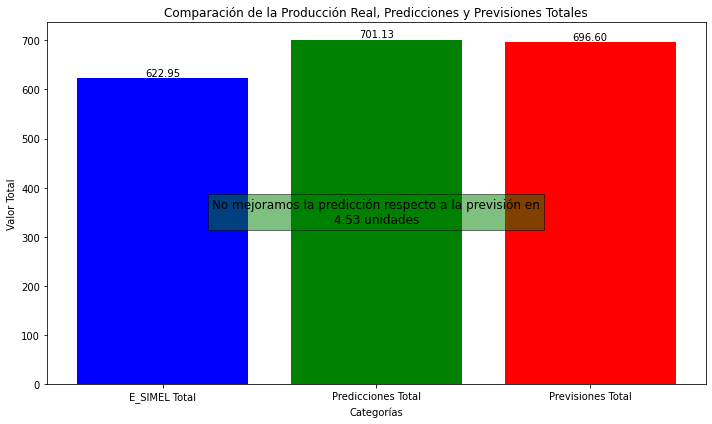

In [33]:
# Valores que cogemos para el gráfico

categorias = ['E_SIMEL Total', 'Predicciones Total', 'Previsiones Total']
valores = [suma_e_simel, sumas_totales_predicciones, sumas_previsiones]

# Creamos un gráfico de barras

plt.figure(figsize=(10, 6))
barra = plt.bar(categorias, valores, color=['blue', 'green', 'red'])

# Añadimos las etiqutas

for rect in barra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Título del gráfico y ponemos las etiquteas a cada barra
    
plt.title('Comparación de la Producción Real, Predicciones y Previsiones Totales')
plt.xlabel('Categorías')
plt.ylabel('Valor Total')


# Ubicamos el texto de la diferencia

pos_y = valores[1] / 2
pos_x = categorias[1]
plt.text(pos_x, pos_y, f'No mejoramos la predicción respecto a la previsión en\n{diferencia:.2f} unidades', ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor='green', alpha=0.5))
plt.tight_layout()
plt.show()

In [34]:
suma_prevision = df_final['PREVISION'].sum()
suma_prevision

696.5999999999999

In [35]:
suma_E_SIMEL = df_final['E_SIMEL'].sum()
suma_E_SIMEL

622.953